# 1 Dependencies import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.quickml.reader import read_csv
from scripts.quickml.plot import feature_distribution_univar, feature_filling, correlation_heatmap, feature_trend_bivar, feature_distribution_bivar, dataframe_distribution_overview
from scripts.quickml.compare import index_lth
from scripts.utils import fill_infos

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(294697)

***
# 2 Data import

In [2]:
data = pd.read_csv("datas/sample.csv", index_col=[0], sep=";")

In [ ]:
data.shape

***
# 3 Overview

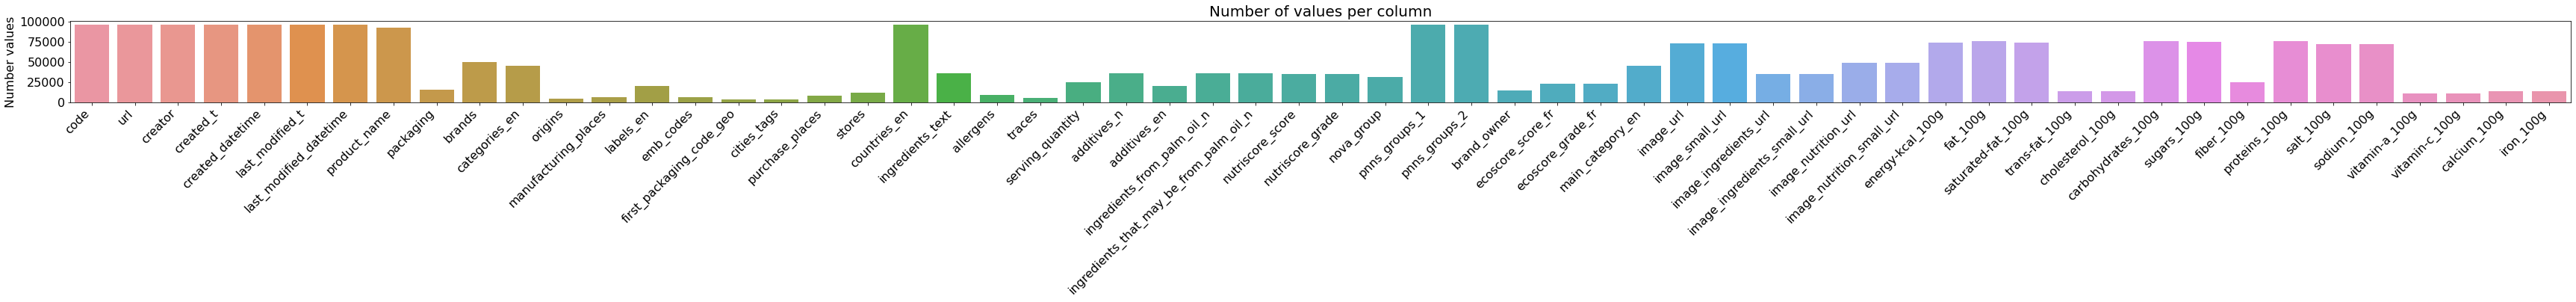

In [3]:
dataframe_distribution_overview(data)

***
# 4 Global correlations

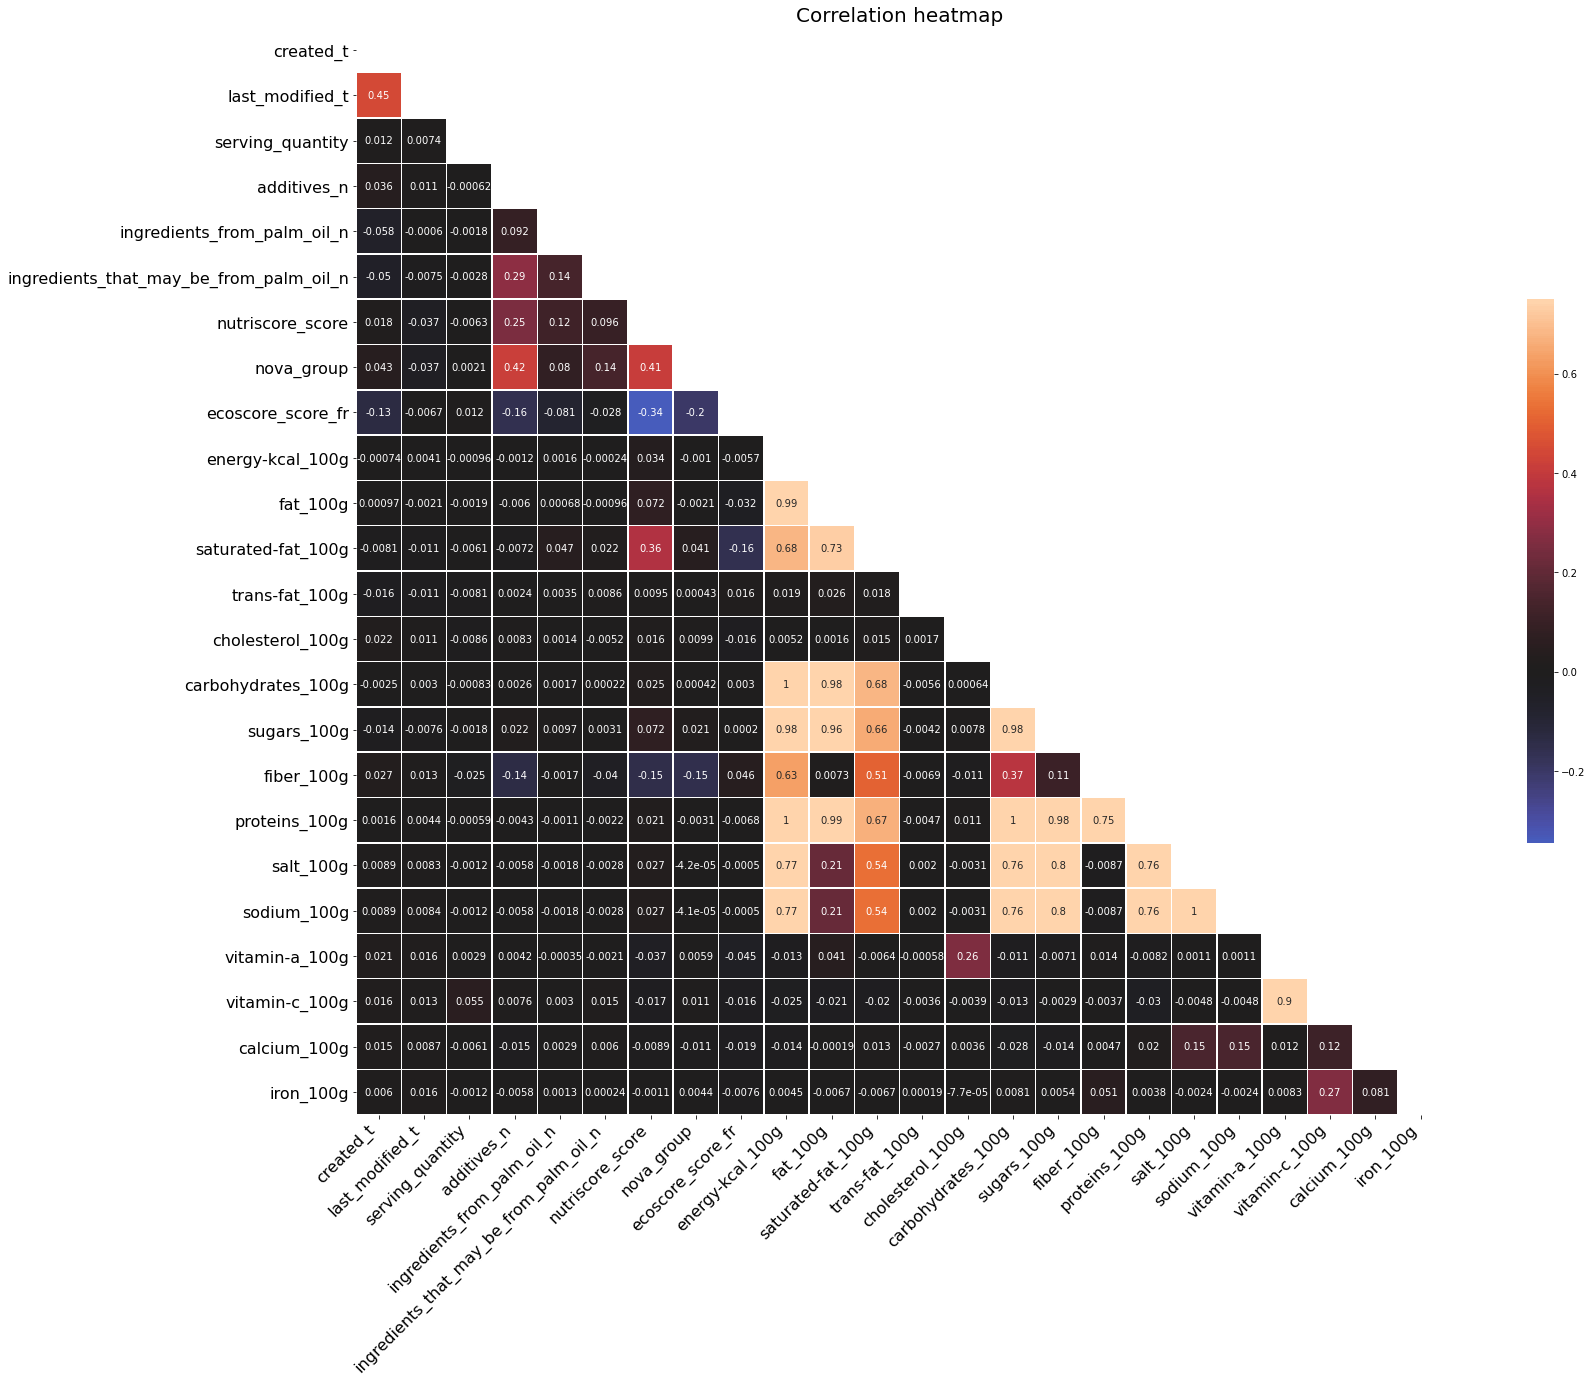

In [4]:
correlation_heatmap(data)

***
# 5 Nutriscore / Ecoscore correlations

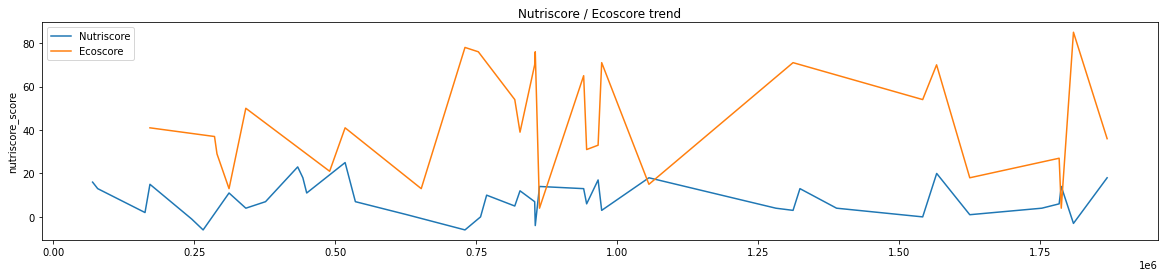

In [5]:
feature_trend_bivar(data, "nutriscore_score", "Nutriscore", "ecoscore_score_fr", "Ecoscore", 1000)

Nutriscore: the bigger the value, the worst the product is.  
Ecoscore: the bigger the value, the worst the environemental impact is.

## Conclusion:
The worst is a product (high nutriscore), the better it is for the environement (low ecoscore).

***
# 6 Nutriscore / Ecoscore distribution

<Figure size 720x432 with 0 Axes>

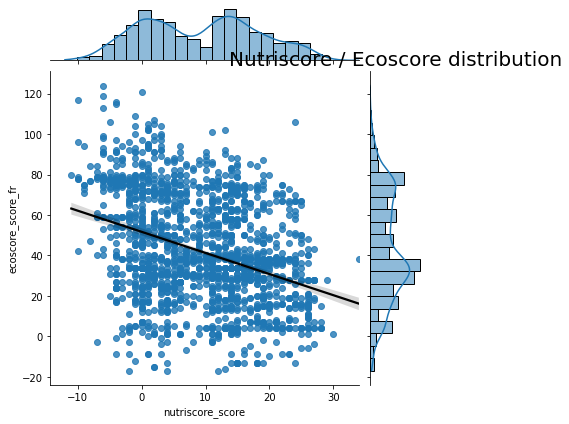

In [6]:
feature_distribution_bivar(data, "nutriscore_score", "Nutriscore", "ecoscore_score_fr", "Ecoscore", divider=10)

***
# 7 Nutriscore / countries disribution

In [7]:
data.iloc[10:].countries_en.head(20)

84359    United States
37201    United States
35011    United States
80712    United States
11570    United States
9742     United States
68909    United States
55271    United States
41805    United States
87982    United States
25956    United States
463             France
51668    United States
68868    United States
70884    United States
68875    United States
74577    United States
52823    United States
57546    United States
61819    United States
Name: countries_en, dtype: object

The feature "countries_en" is in reality a list, as we can see at index 47266: France,United Kingdom.  
We will choose to keep only the last country in this list for each row.

In [8]:
def keep_last_country(row):
    cotr = row["countries_en"]
    splt = cotr.split(",")
    row["countries_en"] = splt[-1]
    return row

data = data[data.countries_en.notna()].apply(lambda row: keep_last_country(row), axis=1)

In [9]:
data.iloc[10:].countries_en.head(20)

84359    United States
37201    United States
35011    United States
80712    United States
11570    United States
9742     United States
68909    United States
55271    United States
41805    United States
87982    United States
25956    United States
463             France
51668    United States
68868    United States
70884    United States
68875    United States
74577    United States
52823    United States
57546    United States
61819    United States
Name: countries_en, dtype: object

Let's see now how the nutriscore is distributed by country.

In [10]:
data_by_countries_nutriscore = data.groupby(["countries_en", "nutriscore_grade"]).nutriscore_grade.agg([len])
data_by_countries_nutriscore.head()

len
countries_en nutriscore_grade     
Albania      b                   1
Aldi         e                   1
Algeria      a                   3
             b                   4
             c                   3

In [11]:
data_by_countries_nutriscore = data_by_countries_nutriscore.reset_index()
data_by_countries_nutriscore.head()

,countries_en,nutriscore_grade,len
0,Albania,b,1
1,Aldi,e,1
2,Algeria,a,3
3,Algeria,b,4
4,Algeria,c,3


<Figure size 720x216 with 0 Axes>

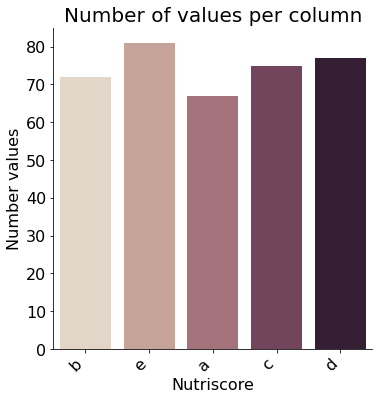

In [13]:
feature_distribution_univar(data_by_countries_nutriscore, "nutriscore_grade", "Nutriscore")

In [14]:
nutriscore_distrib_per_country = data_by_countries_nutriscore.loc[data_by_countries_nutriscore.countries_en.isin(["France", "Germany", "Belgium", "Canad", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

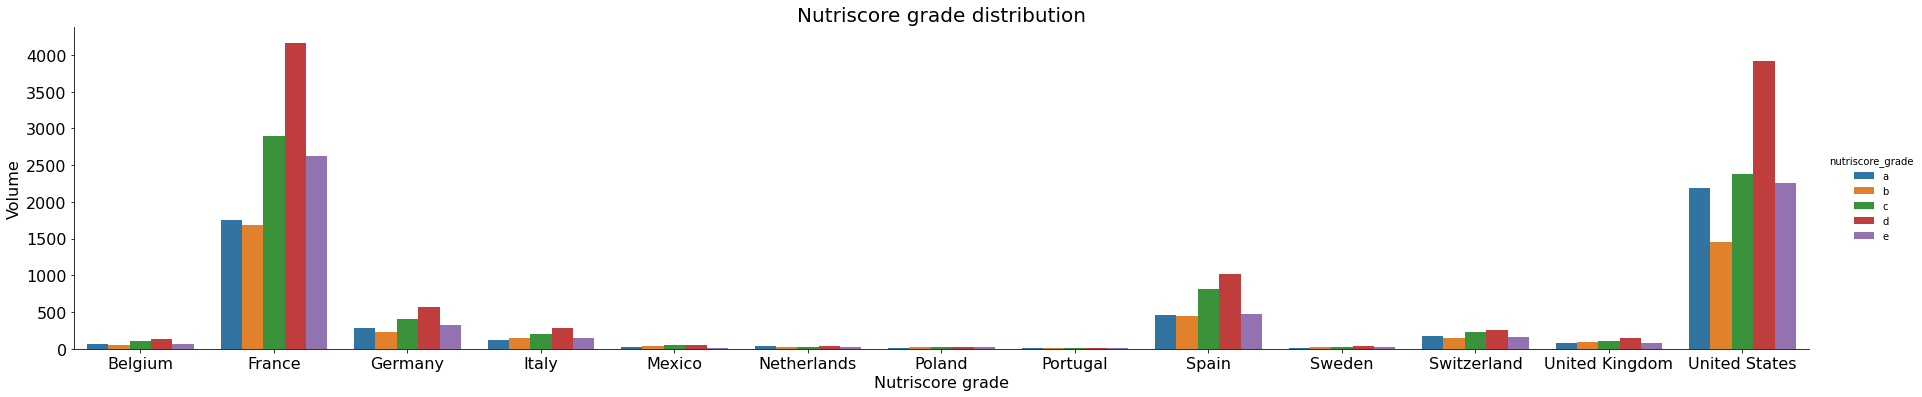

In [15]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="nutriscore_grade", data=nutriscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# 8 Ecoscore / countries distribution

Let's see now how the ecoscore is distributed by country.

In [60]:
data_by_countries_ecoscore = data.groupby(["countries_en", "ecoscore_grade_fr"]).ecoscore_grade_fr.agg([len])
data_by_countries_ecoscore.head()

len
countries_en ecoscore_grade_fr     
Albania      d                    2
Aldi         c                    1
Algeria      b                    2
             c                    6
             d                    7

In [61]:
data_by_countries_ecoscore = data_by_countries_ecoscore.reset_index()
data_by_countries_ecoscore.head()

,countries_en,ecoscore_grade_fr,len
0,Albania,d,2
1,Aldi,c,1
2,Algeria,b,2
3,Algeria,c,6
4,Algeria,d,7


<Figure size 720x216 with 0 Axes>

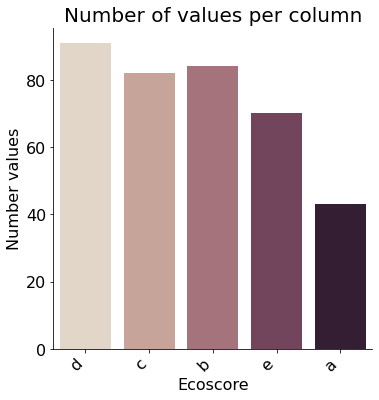

In [62]:
feature_distribution_univar(data_by_countries_ecoscore, "ecoscore_grade_fr", "Ecoscore")

In [64]:
ecoscore_distrib_per_country = data_by_countries_ecoscore.loc[data_by_countries_ecoscore.countries_en.isin(["France", "Germany", "Belgium", "Canad", "Italy", "Mexico", "Netherlands", "Poland", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom", "United States"])]

<Figure size 2160x432 with 0 Axes>

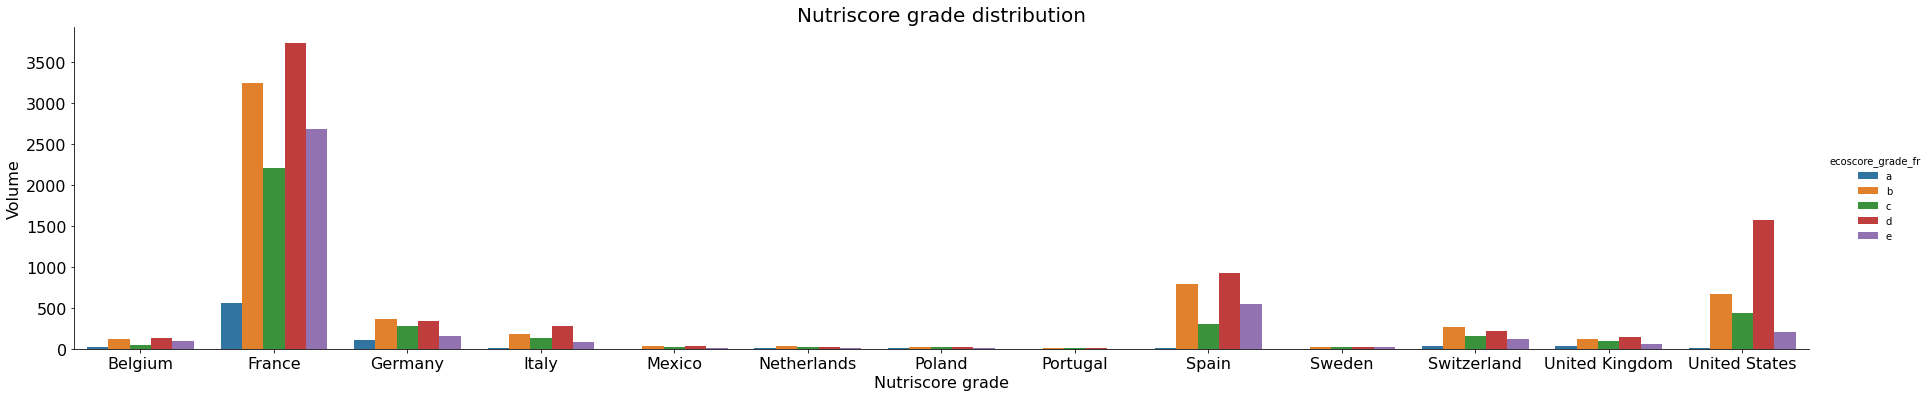

In [65]:
plt.figure(figsize=(30,6))

sns.catplot(x="countries_en", y="len", hue="ecoscore_grade_fr", data=ecoscore_distrib_per_country, kind="bar", height=5, aspect=5)

plt.title("Nutriscore grade distribution", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Nutriscore grade", size=16)
plt.ylabel("Volume", size=16)
plt.show()

***
# ---

## categorical to numerical transformation test

In [66]:
data["ecoscore_CAT"] = data["ecoscore_grade_fr"].astype("category").cat.codes

In [67]:
data["nutriscore_CAT"] = data["nutriscore_grade"].astype("category").cat.codes

In [68]:
data.loc[:, ["ecoscore_CAT", "nutriscore_CAT"]].head()

,ecoscore_CAT,nutriscore_CAT
69539,-1,3
83339,-1,1
14616,-1,-1
35144,-1,-1
35013,-1,-1


## correlation: nutriscore/ecoscore/countries

In [69]:
data["countries_NUM"] = data["countries_en"].astype("category").cat.codes

In [70]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
69539,187,3,-1
83339,187,1,-1
14616,20,-1,-1
35144,187,-1,-1
35013,186,-1,-1


In [71]:
data.loc[:, ["countries_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,countries_NUM,nutriscore_CAT,ecoscore_CAT
countries_NUM,1.000000,0.141943,-0.096057
nutriscore_CAT,0.141943,1.000000,0.455480
ecoscore_CAT,-0.096057,0.455480,1.000000


## correlation: nutriscore/ecoscore/brands

In [72]:
data["brands_NUM"] = data["brands"].astype('category').cat.codes

In [73]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
69539,-1,3,-1
83339,11490,1,-1
14616,11291,-1,-1
35144,-1,-1,-1
35013,15162,-1,-1


In [74]:
data.loc[:, ["brands_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brands_NUM,nutriscore_CAT,ecoscore_CAT
brands_NUM,1.00000,0.17742,0.14230
nutriscore_CAT,0.17742,1.00000,0.45548
ecoscore_CAT,0.14230,0.45548,1.00000


## correlation: nutriscore/ecoscore/packaging

In [75]:
data["packaging_NUM"] = data["packaging"].astype("category").cat.codes

In [76]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
69539,-1,3,-1
83339,-1,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [77]:
data.loc[:, ["packaging_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,packaging_NUM,nutriscore_CAT,ecoscore_CAT
packaging_NUM,1.000000,0.164983,0.173879
nutriscore_CAT,0.164983,1.000000,0.455480
ecoscore_CAT,0.173879,0.455480,1.000000


## correlation: nutriscore/ecoscore/categories_en

In [78]:
data["categories_en_NUM"] = data["categories_en"].astype("category").cat.codes

In [79]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
69539,749,3,-1
83339,2307,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [80]:
data.loc[:, ["categories_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,categories_en_NUM,nutriscore_CAT,ecoscore_CAT
categories_en_NUM,1.000000,0.599485,0.433908
nutriscore_CAT,0.599485,1.000000,0.455480
ecoscore_CAT,0.433908,0.455480,1.000000


## correlation: nutriscore/ecoscore/labels_en

In [81]:
data["labels_en_NUM"] = data["labels_en"].astype("category").cat.codes

In [82]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
69539,-1,3,-1
83339,-1,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [83]:
data.loc[:, ["labels_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,labels_en_NUM,nutriscore_CAT,ecoscore_CAT
labels_en_NUM,1.000000,0.103209,0.134182
nutriscore_CAT,0.103209,1.000000,0.455480
ecoscore_CAT,0.134182,0.455480,1.000000


## correlation: nutriscore/ecoscore/serving_quantity

In [84]:
data["serving_quantity_NUM"] = data["serving_quantity"].astype("category").cat.codes

In [85]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
69539,271,3,-1
83339,530,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [86]:
data.loc[:, ["serving_quantity_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,serving_quantity_NUM,nutriscore_CAT,ecoscore_CAT
serving_quantity_NUM,1.000000,0.282272,0.00657
nutriscore_CAT,0.282272,1.000000,0.45548
ecoscore_CAT,0.006570,0.455480,1.00000


## correlation: nutriscore/ecoscore/pnns_groups_1/pnns_groups_2

In [87]:
data["pnns_groups_1_NUM"] = data["pnns_groups_1"].astype("category").cat.codes

In [88]:
data["pnns_groups_2_NUM"] = data["pnns_groups_2"].astype("category").cat.codes

In [89]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_2_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,pnns_groups_1_NUM,pnns_groups_2_NUM,nutriscore_CAT,ecoscore_CAT
69539,9,3,3,-1
83339,10,39,1,-1
14616,10,39,-1,-1
35144,10,39,-1,-1
35013,10,39,-1,-1


In [90]:
data.loc[:, ["pnns_groups_1_NUM", "pnns_groups_1_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,pnns_groups_1_NUM,pnns_groups_1_NUM,nutriscore_CAT,ecoscore_CAT
pnns_groups_1_NUM,1.000000,1.000000,-0.389837,-0.399445
pnns_groups_1_NUM,1.000000,1.000000,-0.389837,-0.399445
nutriscore_CAT,-0.389837,-0.389837,1.000000,0.455480
ecoscore_CAT,-0.399445,-0.399445,0.455480,1.000000


## correlation: nutriscore/ecoscore/brand_owner

In [91]:
data["brand_owner_NUM"] = data["brand_owner"].astype("category").cat.codes

In [92]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
69539,2849,3,-1
83339,2725,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [93]:
data.loc[:, ["brand_owner_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,brand_owner_NUM,nutriscore_CAT,ecoscore_CAT
brand_owner_NUM,1.000000,0.298535,-0.04491
nutriscore_CAT,0.298535,1.000000,0.45548
ecoscore_CAT,-0.044910,0.455480,1.00000


## correlation: nutriscore/ecoscore/nova_group

In [94]:
data["nova_group_NUM"] = data["nova_group"].astype("category").cat.codes

In [95]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
69539,3,3,-1
83339,3,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [96]:
data.loc[:, ["nova_group_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,nova_group_NUM,nutriscore_CAT,ecoscore_CAT
nova_group_NUM,1.000000,0.485292,0.143351
nutriscore_CAT,0.485292,1.000000,0.455480
ecoscore_CAT,0.143351,0.455480,1.000000


## correlation: nutriscore/ecoscore/additives_en

In [97]:
data["additives_en_NUM"] = data["additives_en"].astype("category").cat.codes

In [98]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].head()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
69539,698,3,-1
83339,-1,1,-1
14616,-1,-1,-1
35144,-1,-1,-1
35013,-1,-1,-1


In [99]:
data.loc[:, ["additives_en_NUM", "nutriscore_CAT", "ecoscore_CAT"]].corr()

,additives_en_NUM,nutriscore_CAT,ecoscore_CAT
additives_en_NUM,1.000000,0.34804,0.082996
nutriscore_CAT,0.348040,1.00000,0.455480
ecoscore_CAT,0.082996,0.45548,1.000000


## corr recap

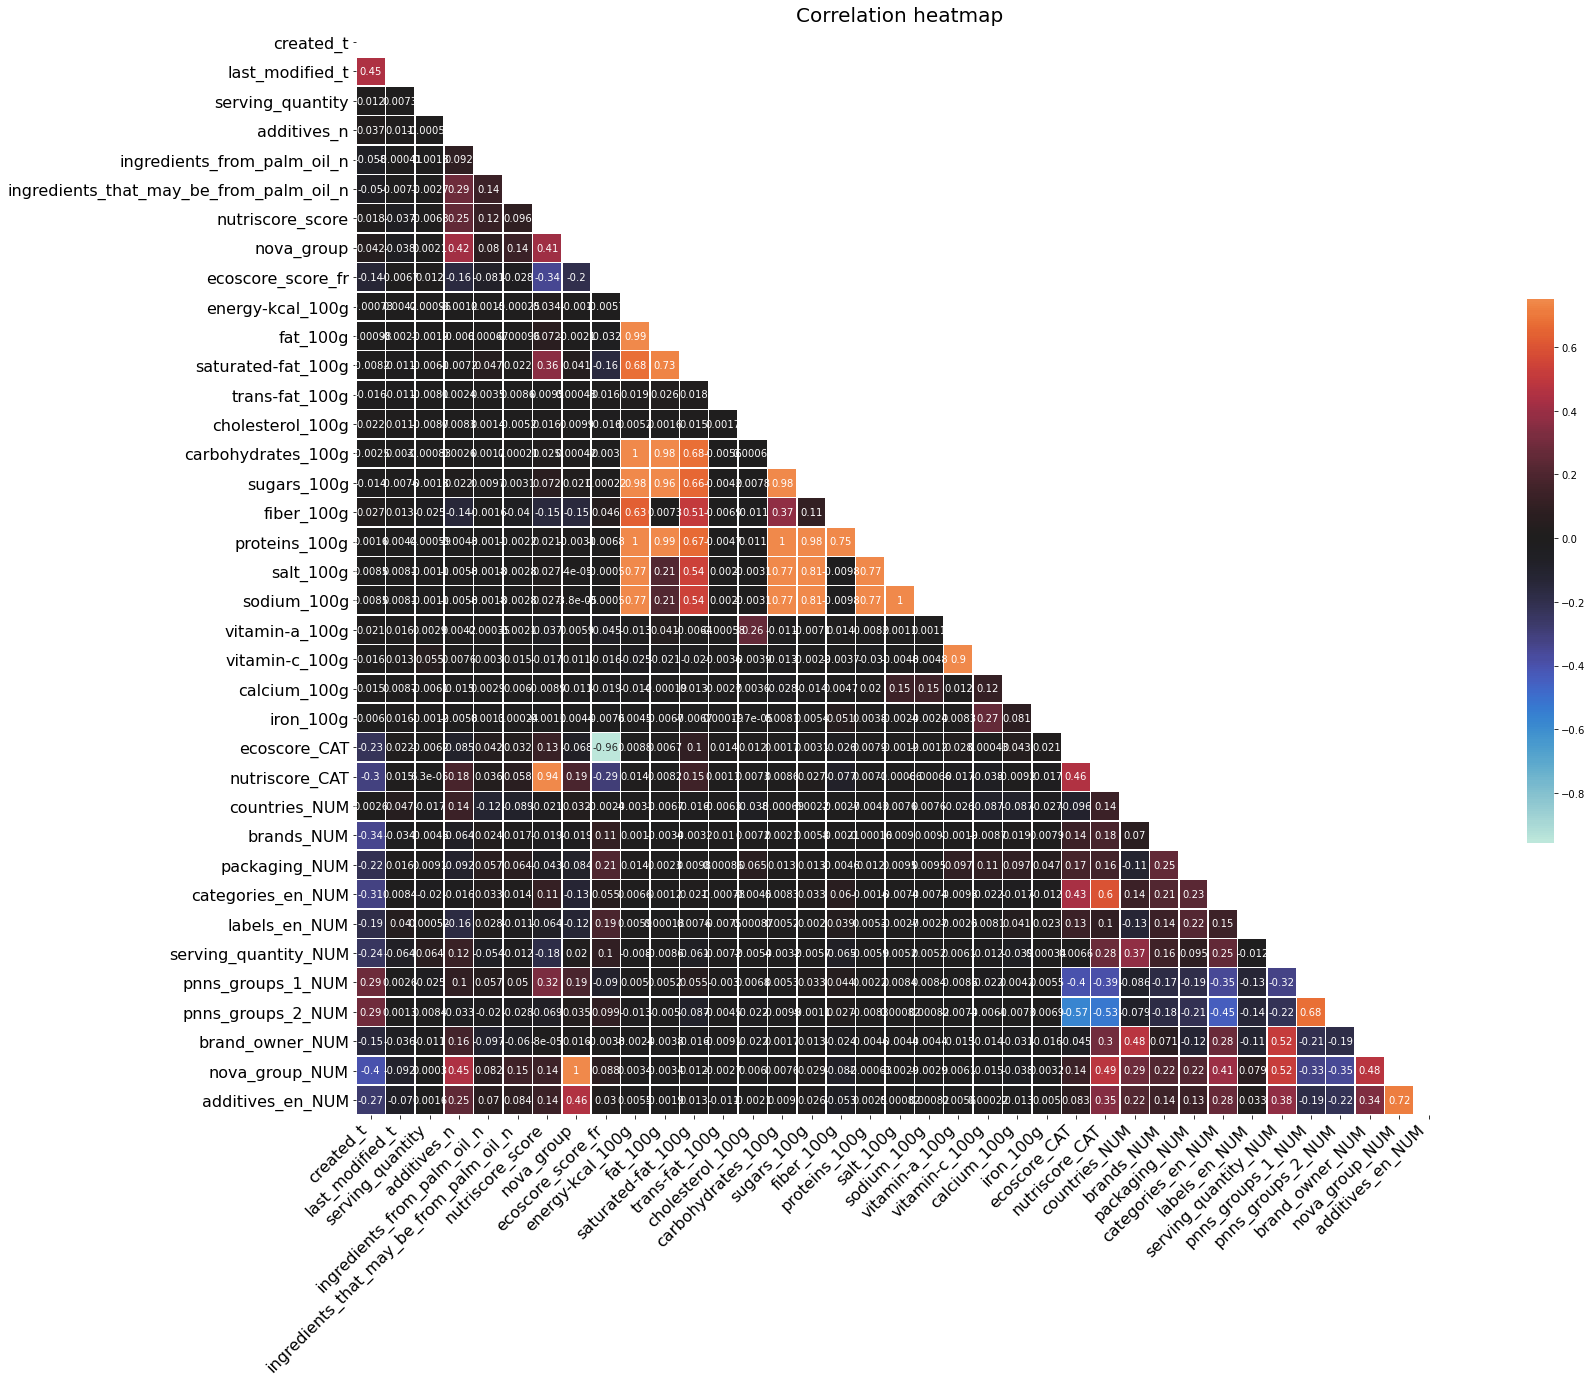

In [102]:
correlation_heatmap(data)

boxplot

pie chart

La définition des quantiles est correctement maîtrisées.

Les éventuelles valeurs aberrantes ont été mises en évidence. Une solution est proposée (elle doit être justifiée si plusieurs choix sont possibles).

Les distributions observées sont correctement caractérisées (uni, bi, multi-modale).

La définition mathématique de la corrélation et les hypothèses sous-jacentes ont été expliquées
